In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import layers, models
import joblib

In [2]:
df = pd.read_csv("uav_flight_dataset.csv")

In [3]:
ae_features = [
    'roll', 'pitch', 'yaw',
    'roll_error', 'pitch_error', 'yaw_error',
    'actuator_total', 'current_per_output',
    'gyro_mag', 'accel_mag',
    'rollspeed_integ', 'pitchspeed_integ', 'yawspeed_integ',
    'voltage_v', 'current_a'
]

df_ae = df[ae_features].dropna()
X = df_ae.to_numpy()

In [4]:
X_train, X_test = train_test_split(X, test_size = 0.2, random_state = 42)

In [5]:
input_dim = X_train.shape[1]
encoding_dim = 8 

In [6]:
autoencoder = models.Sequential([
    layers.Input(shape=(input_dim,)),
    layers.Dense(32, activation='relu'),
    layers.Dense(encoding_dim, activation='relu'),  # bottleneck
    layers.Dense(32, activation='relu'),
    layers.Dense(input_dim, activation='linear')
])

autoencoder.compile(optimizer='adam', loss='mse')

In [7]:
history = autoencoder.fit(
    X_train, X_train,
    epochs=50,
    batch_size=64,
    validation_split=0.1,
    verbose=1
)

Epoch 1/50
606/606 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step - loss: 0.6738 - val_loss: 0.3071
Epoch 2/50
606/606 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.2158 - val_loss: 0.2437
Epoch 3/50
606/606 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.1445 - val_loss: 0.2218
Epoch 4/50
606/606 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.1356 - val_loss: 0.2158
Epoch 5/50
606/606 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.0993 - val_loss: 0.2158
Epoch 6/50
606/606 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.1080 - val_loss: 0.1979
Epoch 7/50
606/606 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0703 - val_loss: 0.1902
Epoch 8/50
606/606 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0780 - val_loss: 0.1750
Epoch 9/50
606/606 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.0820 - val_loss: 0.1691
Epoch 10/50
606/606 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 0.0817 - val_loss: 0.1556
Epoch 11/50
606/606 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0730 - val_loss: 0.1458
Epoch 12/50
606/606 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step

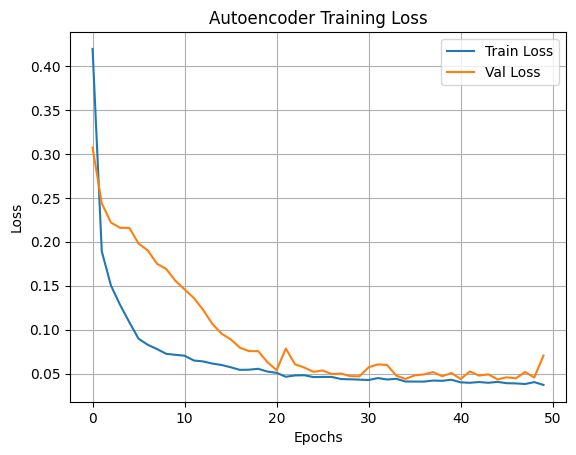

In [8]:
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Autoencoder Training Loss')
plt.legend()
plt.grid(True)
plt.show()

In [9]:
reconstructions = autoencoder.predict(X_test)
mse = np.mean(np.square(X_test - reconstructions), axis=1)

337/337 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


In [10]:
train_recon = autoencoder.predict(X_train)
train_mse = np.mean(np.square(X_train - train_recon), axis=1)
threshold = np.percentile(train_mse, 95)

1347/1347 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step


In [11]:
anomaly_labels = (mse > threshold).astype(int)

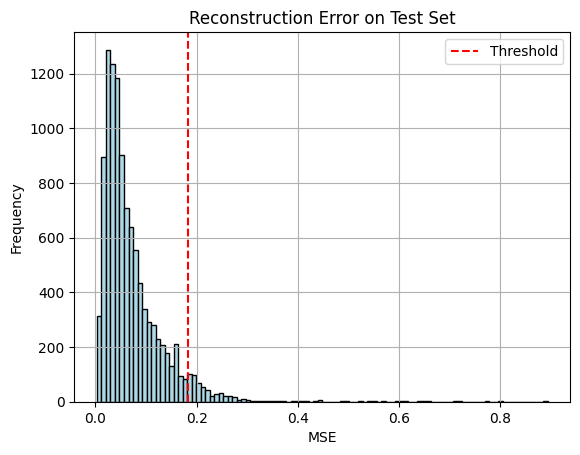

Threshold: 0.18218
Anomalies detected in test set: 561


In [12]:
plt.hist(mse, bins=100, color='lightblue', edgecolor='black')
plt.axvline(threshold, color='red', linestyle='--', label='Threshold')
plt.title("Reconstruction Error on Test Set")
plt.xlabel("MSE")
plt.ylabel("Frequency")
plt.legend()
plt.grid(True)
plt.show()

print(f"Threshold: {threshold:.5f}")
print("Anomalies detected in test set:", np.sum(anomaly_labels))

In [29]:
autoencoder.save('autoencoder_model.keras', include_optimizer = False)